In [25]:
import sys
import os

# Absolute path to your module's directory
module_path = os.path.abspath('/localscratch/zippoema/git/HPA/src/')
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import hpa.rates
import hpa.cluster
import hpa.util

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import gsd.hoomd 
from sklearn import cluster as cl
from scipy.optimize import curve_fit

In [27]:
plt.style.use('default')
plt.style.use('/localscratch/zippoema/md_plots/rates_plot.mplstyle')

In [28]:
path_drop = '/localscratch/zippoema/project_ness/simulations/droplet_200-tdp43-lcd/'
path_slab = '/localscratch/zippoema/project_ness/simulations/slab_200-tdp43-lcd/'
path_ss = '/localscratch/zippoema/project_ness/simulations/no_pser_mass_method/phase_diagram/search_steadystate/'
path_work = '/localscratch/zippoema/working_dir/'

## Compute Gamma ( s(c0_{in}) and s(c0_{out}) )

In [9]:
def compute_Gamma_in(input_file, ser_i, eps=1.0, min_sample=2):
    tr = gsd.hoomd.open(input_file+'dump.gsd', 'r')
    c = np.loadtxt(input_file+'contacts.txt')
    
    c_p = c[c[:, 2] == 1]
    c_dp = c[c[:, 2] == -1]
    times_p = np.rint(c_p[:,0]/200000).astype(int)
    times_dp = np.rint(c_dp[:,0]/200000).astype(int)
    
    in_out = np.zeros((len(tr)+1,len(ser_i)))
    frame = gsd.hoomd.open(input_file+'start.gsd', 'r')[0]
    positions = frame.particles.position
    type_ids = frame.particles.typeid[:30800]
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = values[np.argmax(counts)]
    in_out[0] = labels[ser_i]==condensate_idx
    
    for i, frame in enumerate(tr):
        positions = frame.particles.position
        type_ids = frame.particles.typeid[:30800]
        db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
        labels = db.labels_
        values, counts = np.unique(labels[:30800], return_counts=True)
        condensate_idx = values[np.argmax(counts)]
        in_out[i+1] = labels[ser_i]==condensate_idx
    
    count_in_p = 0
    count_out_p = 0
    for i, tt in enumerate(times_p):
        ser_index = np.where(ser_i==c_p[i,1])[0][0]
        count_in_p += int(in_out[tt,ser_index])
        if not in_out[tt,ser_index]:
            count_out_p +=1
            print(i, tt, c_p[i,1], c_p[i,5])
    
    count_in_dp = 0
    count_out_dp = 0
    for i, tt in enumerate(times_dp):
        ser_index = np.where(ser_i==c_dp[i,1])[0][0]
        count_in_dp += int(in_out[tt,ser_index])
        if not in_out[tt,ser_index]:
            count_out_dp +=1
    
    return count_in_dp-count_in_p, count_out_dp-count_out_p

In [7]:
ser_i = np.array([266, 273, 292, 305, 317, 332, 333, 342, 347, 350, 369, 373, 375, 377, 379, 387, 389, 393, 395, 403, 404, 407, 409, 410])-260-1 
ser_i = np.array([ ser_i+154*j for j in range(200) ]).flatten()



In [8]:
delta_n_in = 0
delta_n_out = 0
nsims = 30
for s in tqdm(range(1,nsims+1)):
    input_file = path_work+f'no_driving_slab/compute_gamma_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim{s}_sh_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_'
    tmp_in, tmp_out = compute_Gamma_in(input_file, ser_i, eps=1.0, min_sample=2)
    delta_n_in += tmp_in
    delta_n_out += tmp_out
delta_n_in /= nsims
delta_n_out /= nsims

  0%|                                                                            | 0/30 [00:00<?, ?it/s]


OSError: [Errno 9] Bad file descriptor: '/localscratch/zippoema/working_dir/no_driving_slab/compute_gamma_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_sh_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump.gsd'

In [13]:
delta_n_in, delta_n_out

(-14.833333333333334, 2.4)

## Compute diffusion coefficient in dilute

In [8]:
dtimes, msd = hpa.util.compute_msd('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_unwrapped.gsd')

/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [24]:
def linear(x,a,b):
    return x*a+b

In [29]:
popt, pcov = curve_fit(linear, dtimes[:30],msd[:30])

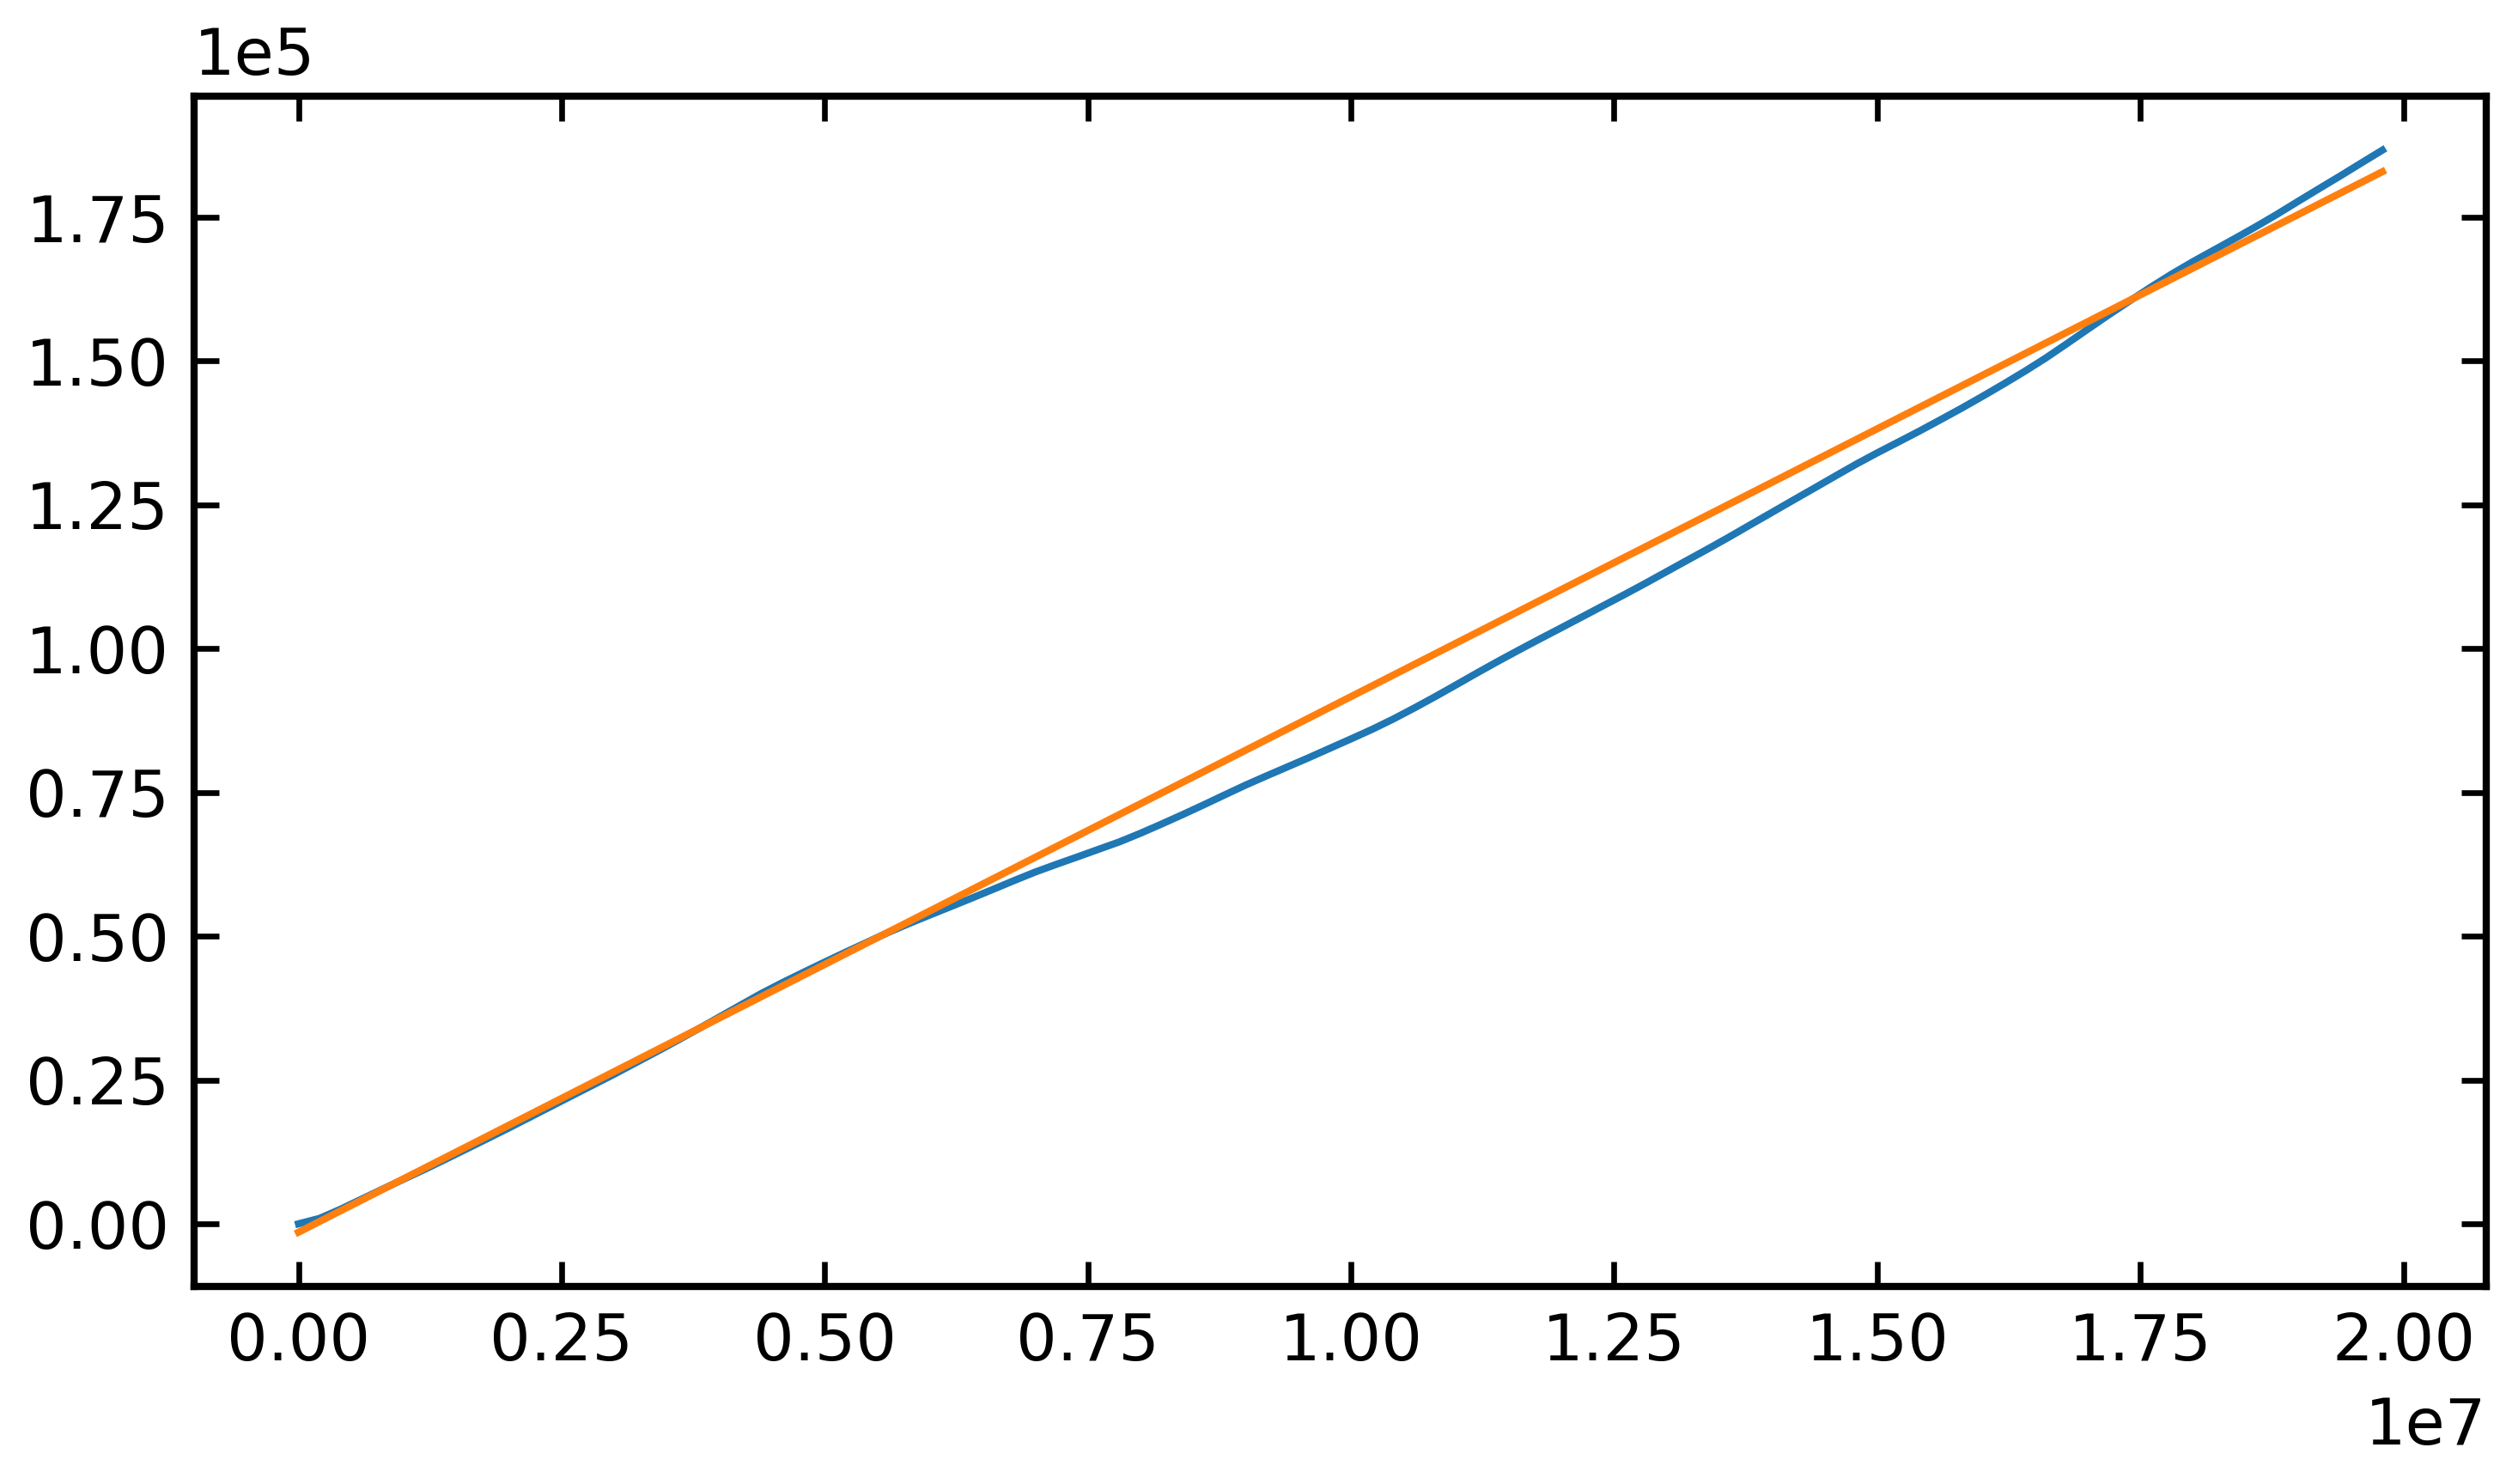

In [33]:
plt.plot(dtimes[:100],msd[:100])
plt.plot(dtimes[:100], linear(dtimes[:100], *popt))
#plt.xscale('log')
#plt.yscale('log')

In [28]:
popt, np.sqrt(pcov.diagonal())

(array([ 9.24003880e-03, -3.33066868e+03]),
 array([5.50520663e-05, 6.30916865e+02]))

In [12]:
dtimes, rg = hpa.util.compute_radius_of_gyration_from_gsd('/localscratch/zippoema/project_ness/analysis/compute_diffusion_dilute/sim_single-tdp43-lcd/sim_p-tdp43_dump_centered.gsd')

In [13]:
np.mean(rg), np.std(rg)/np.sqrt(len(dtimes)-1)

(2.9585966079235075, 0.03278226613549391)

# Compute concentrations in equilibruim

In [10]:
def compute_density_profile(gsd_file, axis=2, nbins=100, group=None):
    """
    Compute the density profile along a specified axis for a centered trajectory.

    Parameters
    ----------
    gsd_file : str
        Path to the GSD trajectory file.
    axis : int
        Axis along which to compute the profile: 0=x, 1=y, 2=z.
    nbins : int
        Number of bins along the axis.
    group : list of int or None
        Particle indices to include. If None, include all particles.

    Returns
    -------
    bin_centers : np.ndarray
        Center coordinates of bins along the axis.
    density : np.ndarray
        Average particle density in each bin.
    """
    traj = gsd.hoomd.open(gsd_file, 'rb')
    n_particles = traj[0].particles.N

    if group is None:
        group = np.arange(n_particles)
    else:
        group = np.array(group)

    # Collect all positions along the chosen axis
    positions = []
    for frame in traj:
        pos = frame.particles.position[group, axis]
        positions.append(pos)
    positions = np.concatenate(positions)  # all frames

    # Determine bin edges
    zmin, zmax = positions.min(), positions.max()
    bins = np.linspace(zmin, zmax, nbins + 1)

    # Compute histogram
    counts, edges = np.histogram(positions, bins=bins)

    # Convert to density: counts per bin volume
    bin_width = edges[1] - edges[0]
    # For a 1D profile along axis, volume = bin_width * box area perpendicular
    # Approximate box area using first frame
    box = traj[0].configuration.box[:3]
    if axis == 0:
        area = box[1] * box[2]
    elif axis == 1:
        area = box[0] * box[2]
    else:
        area = box[0] * box[1]

    density = counts / (len(traj) * area * bin_width)  # average over frames
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    return bin_centers, density

In [154]:
bin_centers, density = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=800)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),


In [155]:
bin_centers_tdp, density_tdp = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=800, group=[i for i in range(30800)])


In [156]:
bin_centers_ck1d, density_ck1d = compute_density_profile(path_work+'no_driving_slab/sim_eq_slab_200-tdp43-lcd_2-ck1d-open_10-pp3/sim1_eq_slab_200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_dump_centered.gsd',
                                               axis=2, nbins=200, group=[i for i in range(30800,30800+292+292)])


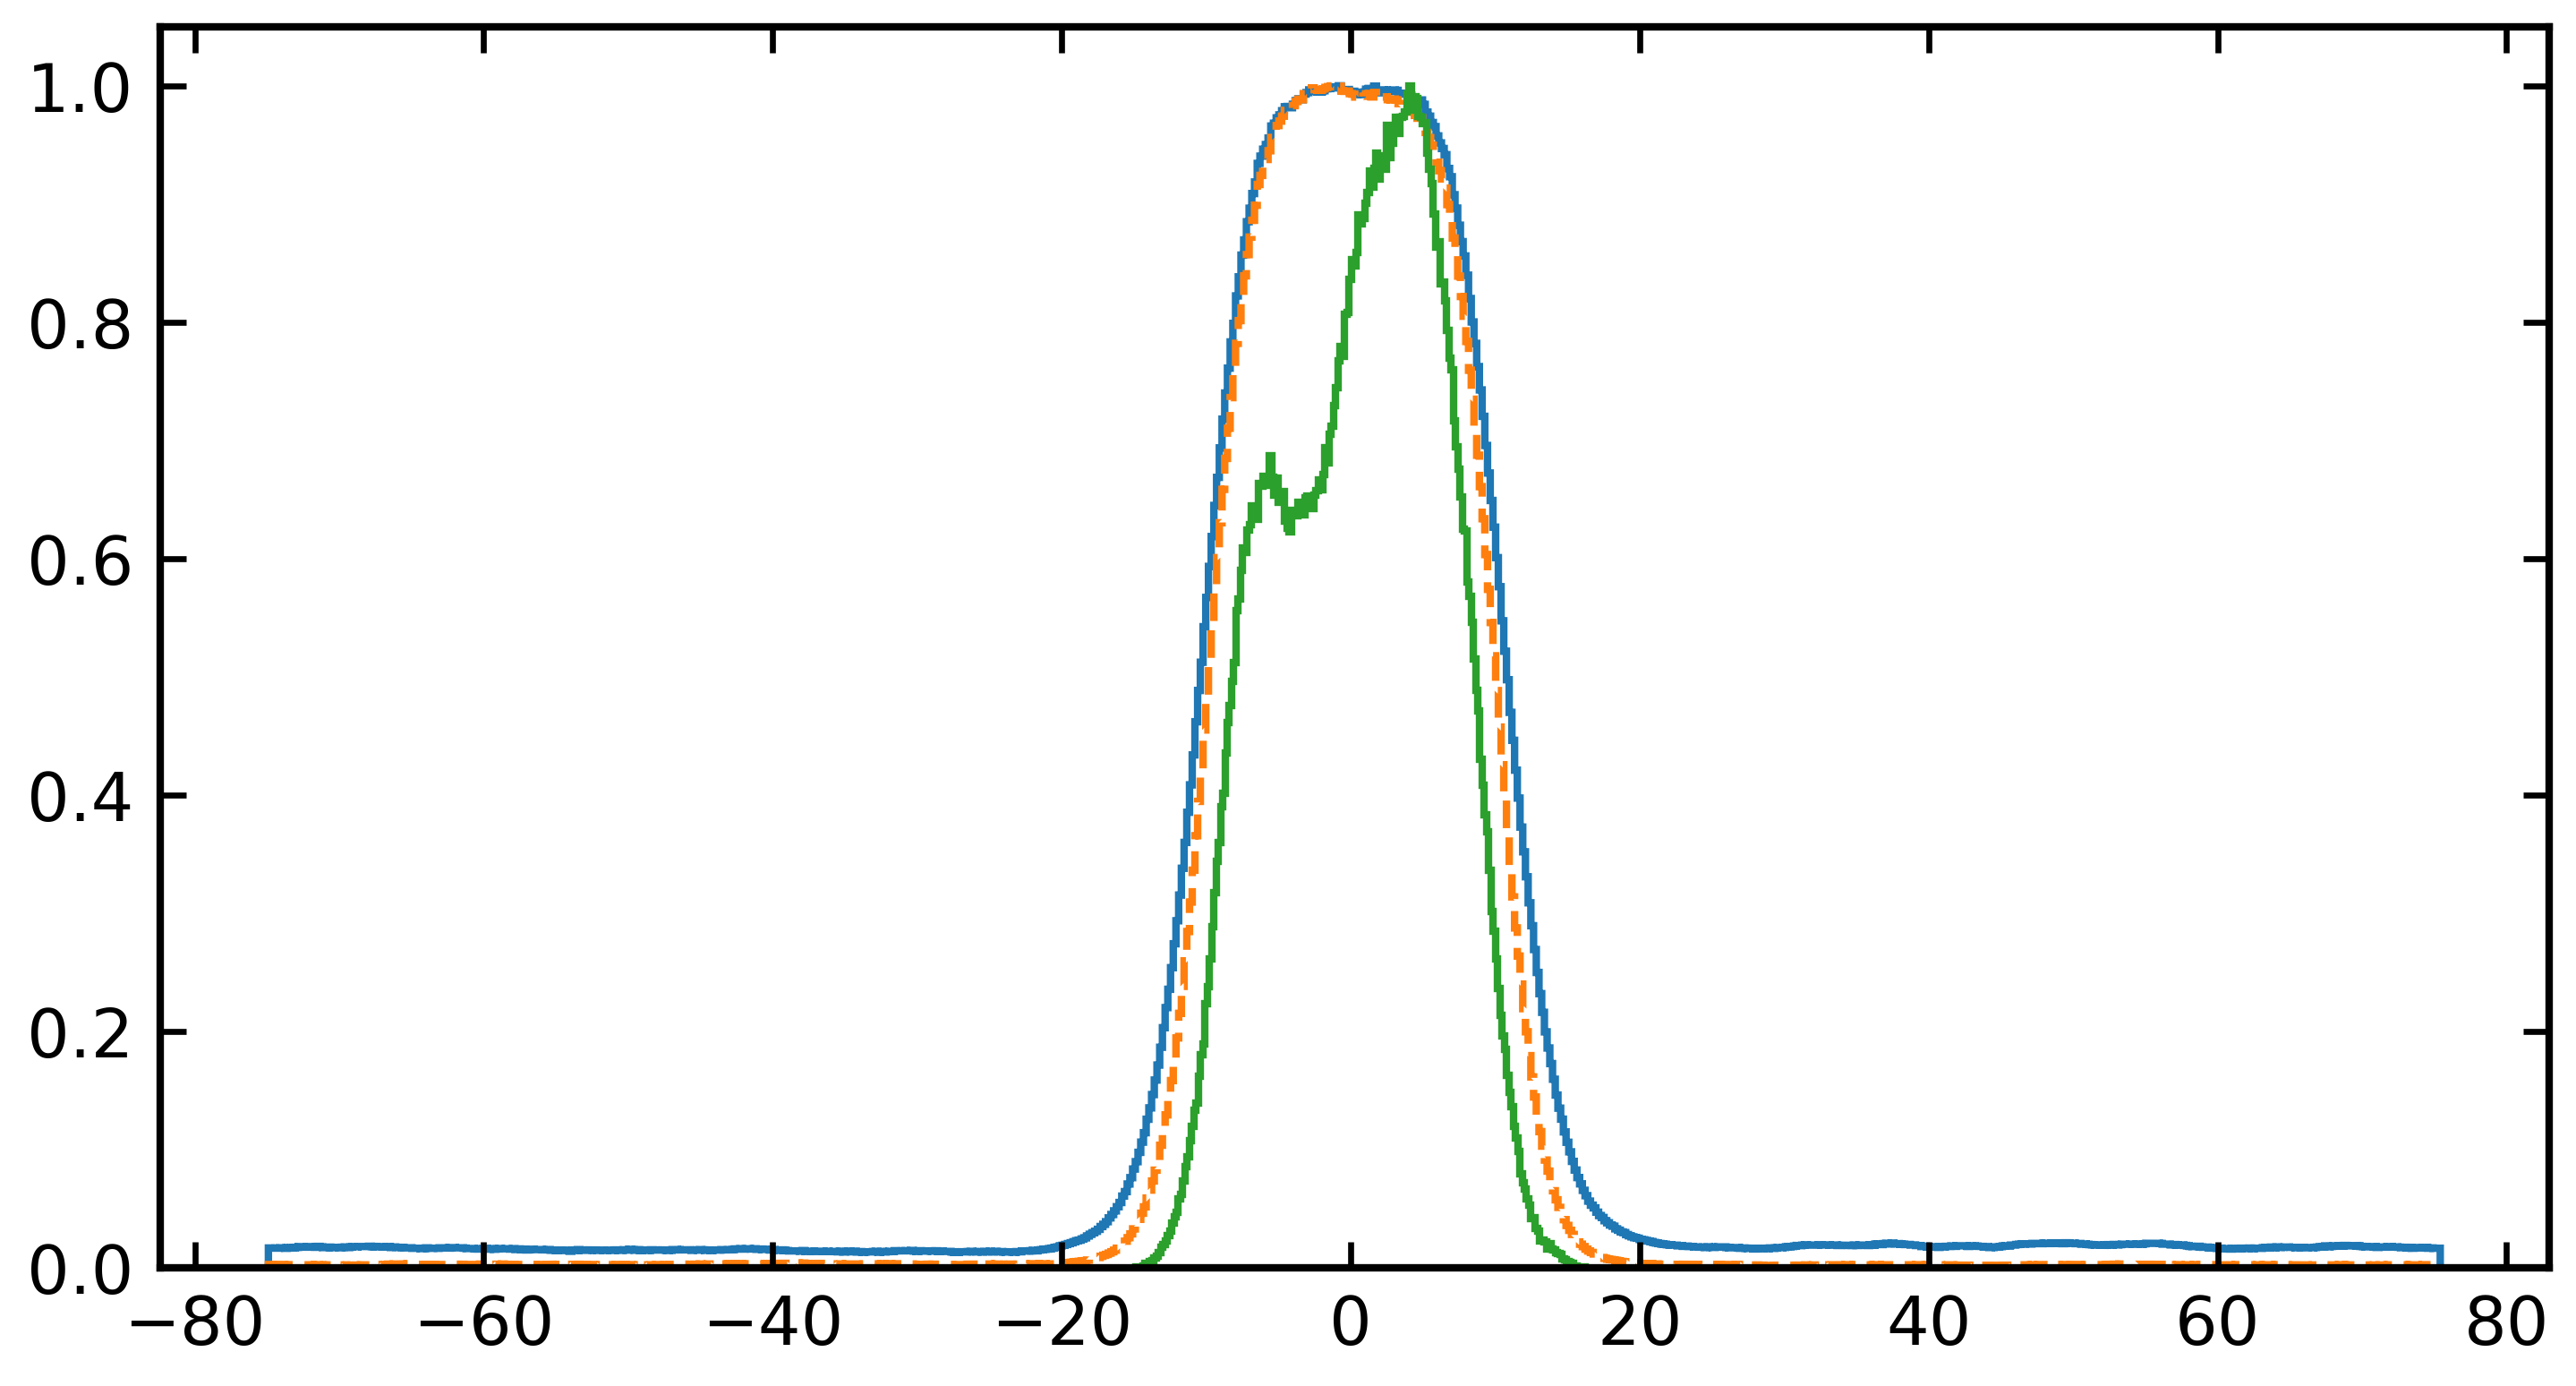

In [157]:
plt.stairs(density/np.max(density), np.append(bin_centers,bin_centers[-1]+0.5))
plt.stairs(density_tdp/np.max(density_tdp), np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5), ls='--')
plt.stairs(density_ck1d/np.max(density_ck1d), np.append(bin_centers_ck1d,bin_centers_ck1d[-1]+0.5))

In [158]:
def tanh_general(x,a,b,c,d):
    return a+b*np.tanh(c*(x-d))

In [159]:
popt_r, pcov_r = curve_fit(tanh_general, bin_centers_tdp[int(len(bin_centers_tdp)/2):], density_tdp[int(len(bin_centers_tdp)/2):], p0=[1.5, -1.49, 0.21, 8])
popt_l, pcov_l = curve_fit(tanh_general, bin_centers_tdp[:int(len(bin_centers_tdp)/2)], density_tdp[:int(len(bin_centers_tdp)/2)], p0=[1.5, 1.5, 0.21, -8])

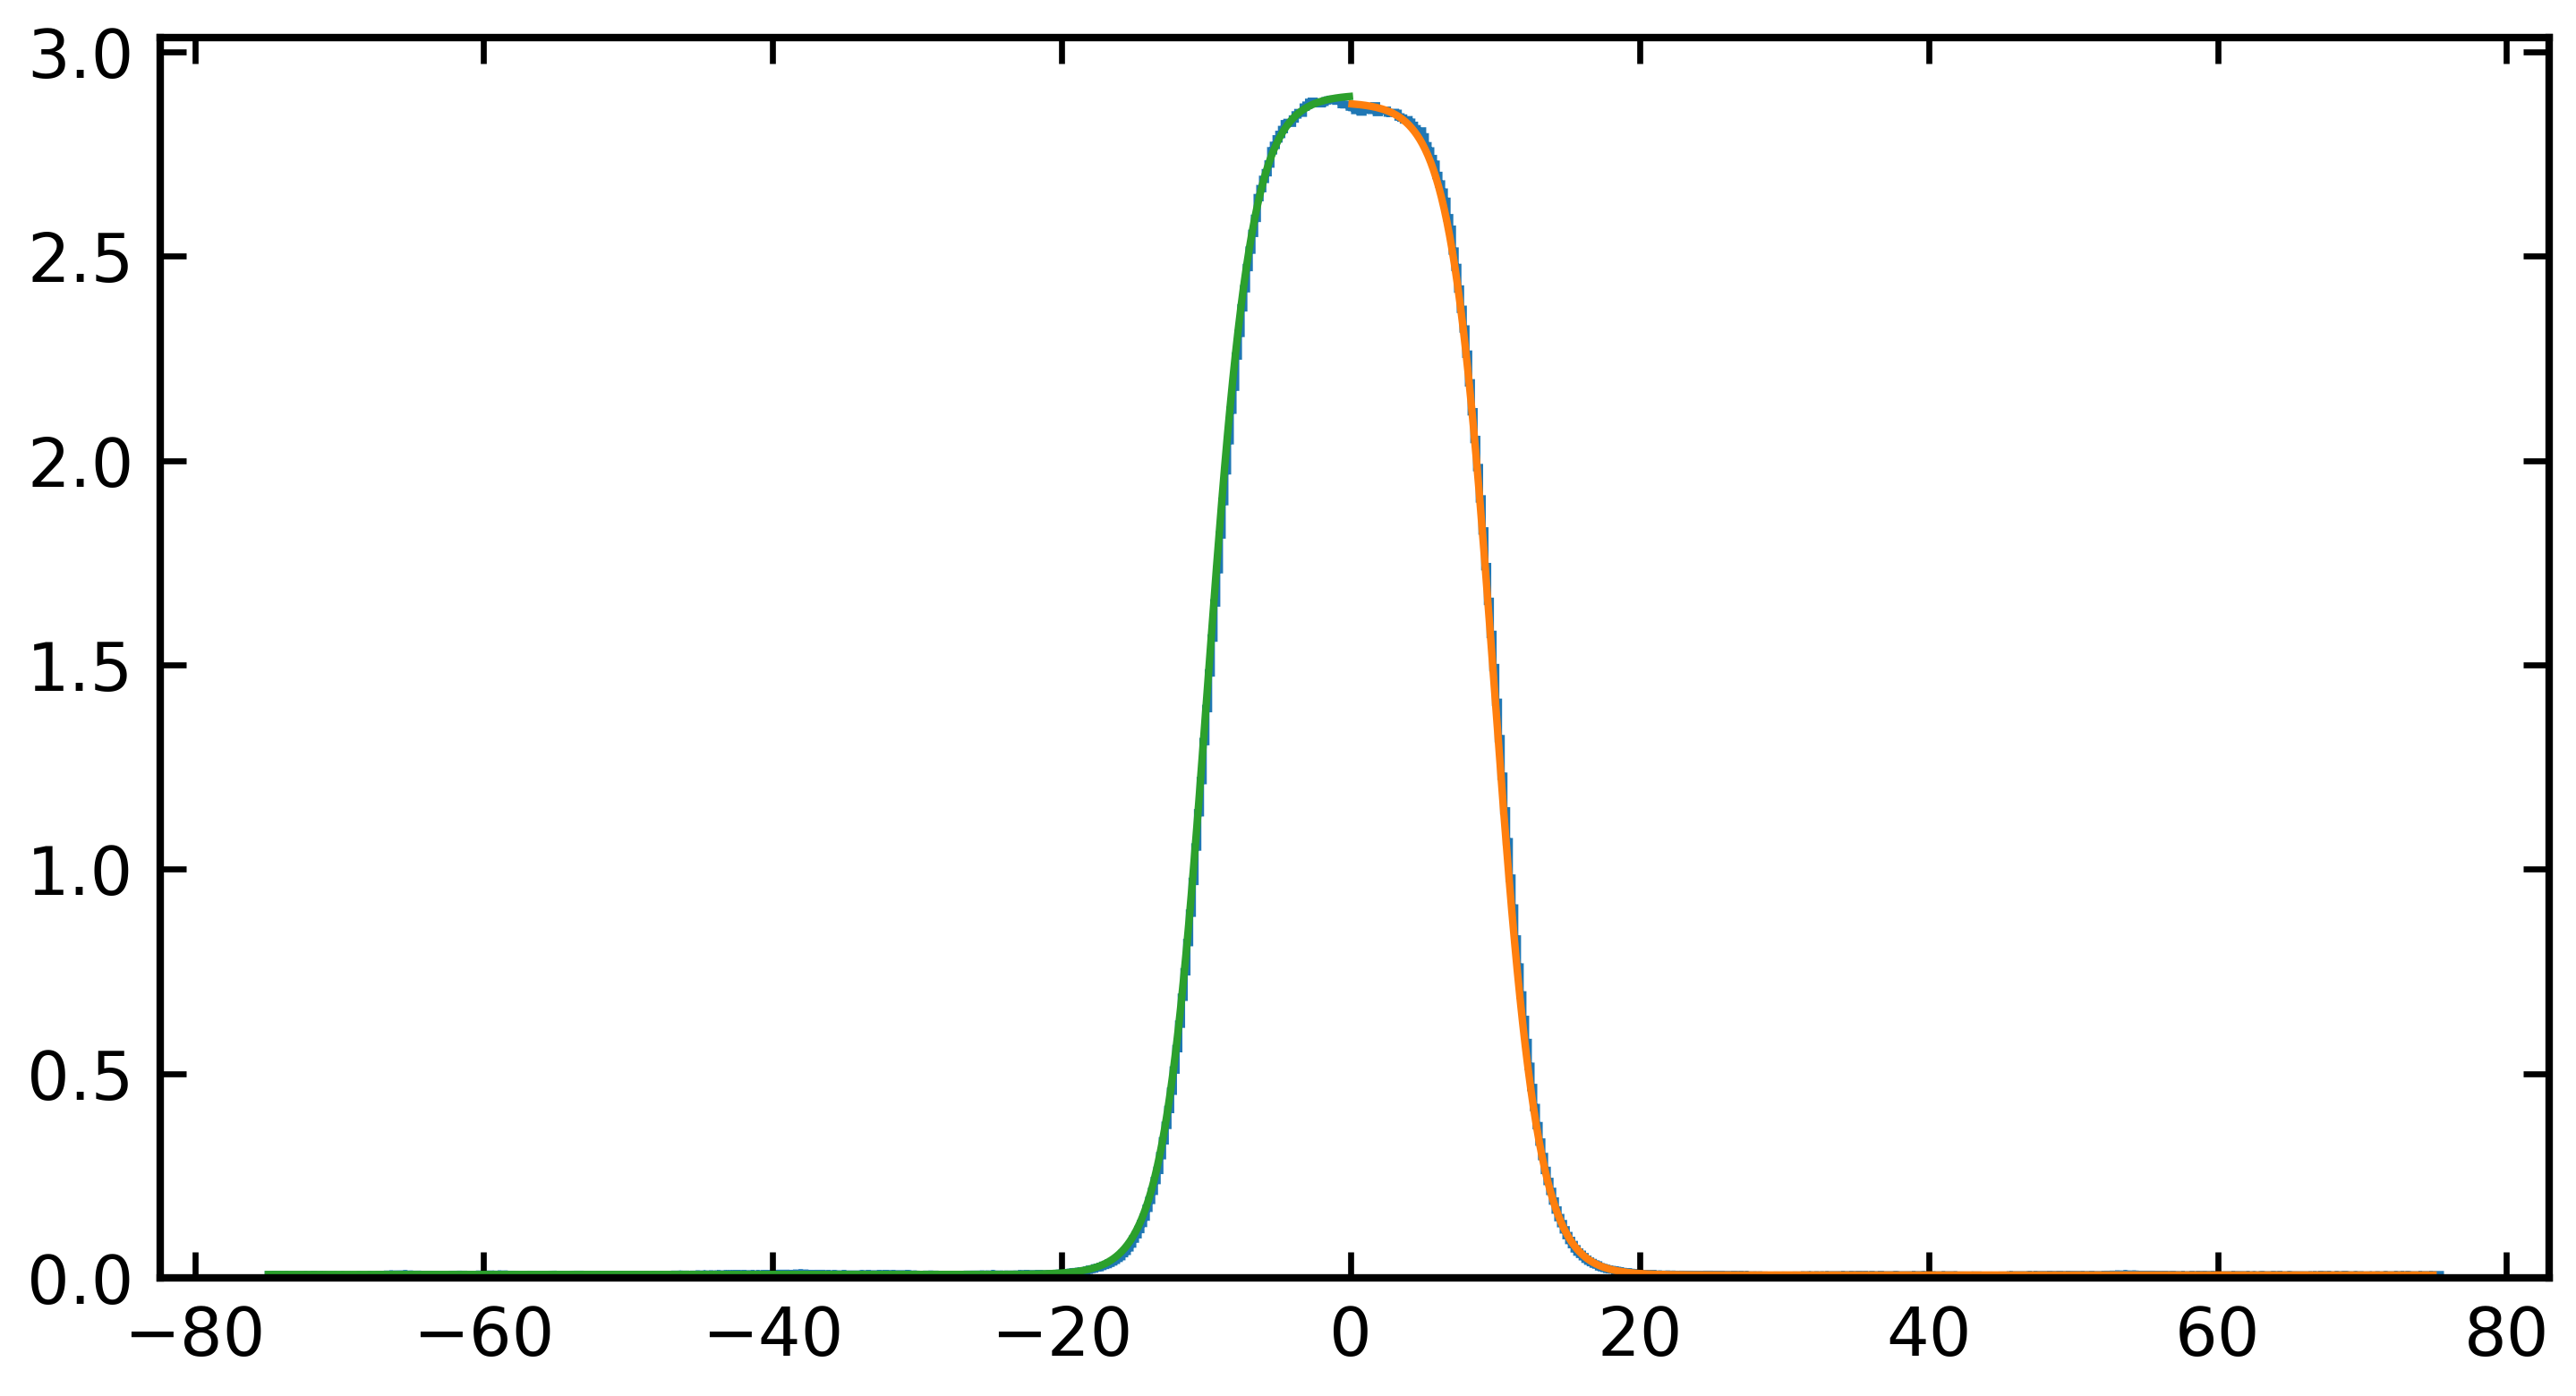

In [160]:
plt.stairs(density_tdp, np.append(bin_centers_tdp,bin_centers_tdp[-1]+0.5))
plt.plot( bin_centers_tdp[int(len(bin_centers_tdp)/2):], tanh_general(bin_centers_tdp[int(len(bin_centers_tdp)/2):], *popt_r) )
plt.plot( bin_centers_tdp[:int(len(bin_centers_tdp)/2)], tanh_general(bin_centers_tdp[:int(len(bin_centers_tdp)/2)], *popt_l) )


In [161]:
c0_in = (popt_r[0]+np.abs(popt_r[1]) + popt_l[0]+np.abs(popt_l[1]))/2
c0_in

2.8859140926811824

In [162]:
c0_out = (popt_r[0]-np.abs(popt_r[1]) + popt_l[0]-np.abs(popt_l[1]))/2
c0_out

0.007226480664372259

In [163]:
w = (1/popt_r[2] + 1/popt_l[2])/2
w

3.0291246772039377

## Cluster sizes and phospho rates

In [29]:
times_5us = np.arange(0,2500,20)
times_ss = np.arange(0,3750,20)
times_ss*200000/1e8

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
       1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
       1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16,
       2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 ,
       2.64, 2.68, 2.72, 2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04,
       3.08, 3.12, 3.16, 3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48,
       3.52, 3.56, 3.6 , 3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92,
       3.96, 4.  , 4.04, 4.08, 4.12, 4.16, 4.2 , 4.24, 4.28, 4.32, 4.36,
       4.4 , 4.44, 4.48, 4.52, 4.56, 4.6 , 4.64, 4.68, 4.72, 4.76, 4.8 ,
       4.84, 4.88, 4.92, 4.96, 5.  , 5.04, 5.08, 5.12, 5.16, 5.2 , 5.24,
       5.28, 5.32, 5.36, 5.4 , 5.44, 5.48, 5.52, 5.56, 5.6 , 5.64, 5.68,
       5.72, 5.76, 5.8 , 5.84, 5.88, 5.92, 5.96, 6.

In [11]:
pSer_200_2_10_pre, d_pSer_200_2_10_pre = hpa.rates.pSer_per_chain(dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_dump.gsd', 
                                              n_sims=1, times=times_5us, len_prot=154, n_prot=200)

pSer_200_2_10_pre1, d_pSer_200_2_10_pre1 = hpa.rates.pSer_per_chain(dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_5us_dump.gsd', 
                                              n_sims=1, times=times_5us, len_prot=154, n_prot=200)

pSer_200_2_10_pre2, d_pSer_200_2_10_pre2 = hpa.rates.pSer_per_chain(dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_10us_dump.gsd', 
                                              n_sims=1, times=times_5us, len_prot=154, n_prot=200)

pSer_200_2_10_pre3, d_pSer_200_2_10_pre3 = hpa.rates.pSer_per_chain(dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_15us_dump.gsd', 
                                              n_sims=1, times=times_5us, len_prot=154, n_prot=200)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
100%|███████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 2164.40it/s]


In [30]:
pSer_200_2_10_1, d_pSer_200_2_10_1 = hpa.rates.pSer_per_chain(dirpath=path_drop+'sim_oscillation_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_osc_dump.gsd', 
                                              n_sims=[1], times=times_ss, len_prot=154, n_prot=200)


/localscratch/zippoema/lib/python_envs/hpa_env/lib/python3.11/site-packages/gsd/hoomd.py:1125: FutureWarning: The 'rb' mode is deprecated, use 'r'
  gsdfileobj = fl.open(name=str(name),
100%|█████████████████████████████████████████████████████████████████| 188/188 [00:31<00:00,  5.94it/s]


In [31]:
pSer_200_2_10_2, d_pSer_200_2_10_2 = hpa.rates.pSer_per_chain(dirpath=path_drop+'sim_oscillation_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_osc_dump.gsd', 
                                              n_sims=[2], times=times_ss, len_prot=154, n_prot=200)

100%|█████████████████████████████████████████████████████████████████| 188/188 [00:29<00:00,  6.31it/s]


In [32]:
pSer_200_2_10_3, d_pSer_200_2_10_3 = hpa.rates.pSer_per_chain(dirpath=path_drop+'sim_oscillation_200-tdp43-lcd_2-ck1d-open_10-pp3/', 
                                              file_suffix='200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_osc_dump.gsd', 
                                              n_sims=[3], times=times_ss, len_prot=154, n_prot=200)

100%|█████████████████████████████████████████████████████████████████| 188/188 [00:35<00:00,  5.32it/s]


In [13]:
dirpath=path_ss+'search_200-tdp43-lcd_2-ck1d-open_10-pp3/'
file_suffix='200-tdp43-lcd-2000pSer_2-com-ck1d-open_10-com-pp3_CAL3_search_'

n_chains_arr_pre = np.zeros((len(times_5us)*4,200))
with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_5us)):
        frame = input_gsd[int(tt)]
        tmp_nc_5ck1d = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr_pre[i] = tmp_nc_5ck1d

with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'5us_dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for j, tt in enumerate(tqdm(times_5us)):
        frame = input_gsd[int(tt)]
        tmp_nc_5ck1d = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr_pre[i+j+1] = tmp_nc_5ck1d

with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'10us_dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for k, tt in enumerate(tqdm(times_5us)):
        frame = input_gsd[int(tt)]
        tmp_nc_5ck1d = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr_pre[i+j+k+1+1] = tmp_nc_5ck1d

with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'15us_dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for l, tt in enumerate(tqdm(times_5us)):
        frame = input_gsd[int(tt)]
        tmp_nc_5ck1d = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr_pre[i+j+k+l+1+1+1] = tmp_nc_5ck1d

2500


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.55it/s]


2500


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.58it/s]


2500


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.49it/s]


2502


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:13<00:00,  9.46it/s]


In [33]:
dirpath=path_drop+'sim_oscillation_200-tdp43-lcd_2-ck1d-open_10-pp3/'
file_suffix='200-tdp43-lcd_2-com-ck1d-open_10-com-pp3_CAL3_osc_'

In [34]:
n_chains_arr1 = np.zeros((len(times_ss),200))
with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr1[i] = tmp_nc


5000


100%|█████████████████████████████████████████████████████████████████| 188/188 [00:40<00:00,  4.68it/s]


In [35]:
n_chains_arr2 = np.zeros((len(times_ss),200))
with gsd.hoomd.open(dirpath+f'sim2_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr2[i] = tmp_nc


4000


100%|█████████████████████████████████████████████████████████████████| 188/188 [00:39<00:00,  4.80it/s]


In [36]:
n_chains_arr3 = np.zeros((len(times_ss),200))
with gsd.hoomd.open(dirpath+f'sim3_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr3[i] = tmp_nc


3750


100%|█████████████████████████████████████████████████████████████████| 188/188 [00:22<00:00,  8.37it/s]


In [37]:
condensate_size_t1 = np.max(n_chains_arr1, axis=1)
condensate_size_t2 = np.max(n_chains_arr2, axis=1)
condensate_size_t3 = np.max(n_chains_arr3, axis=1)

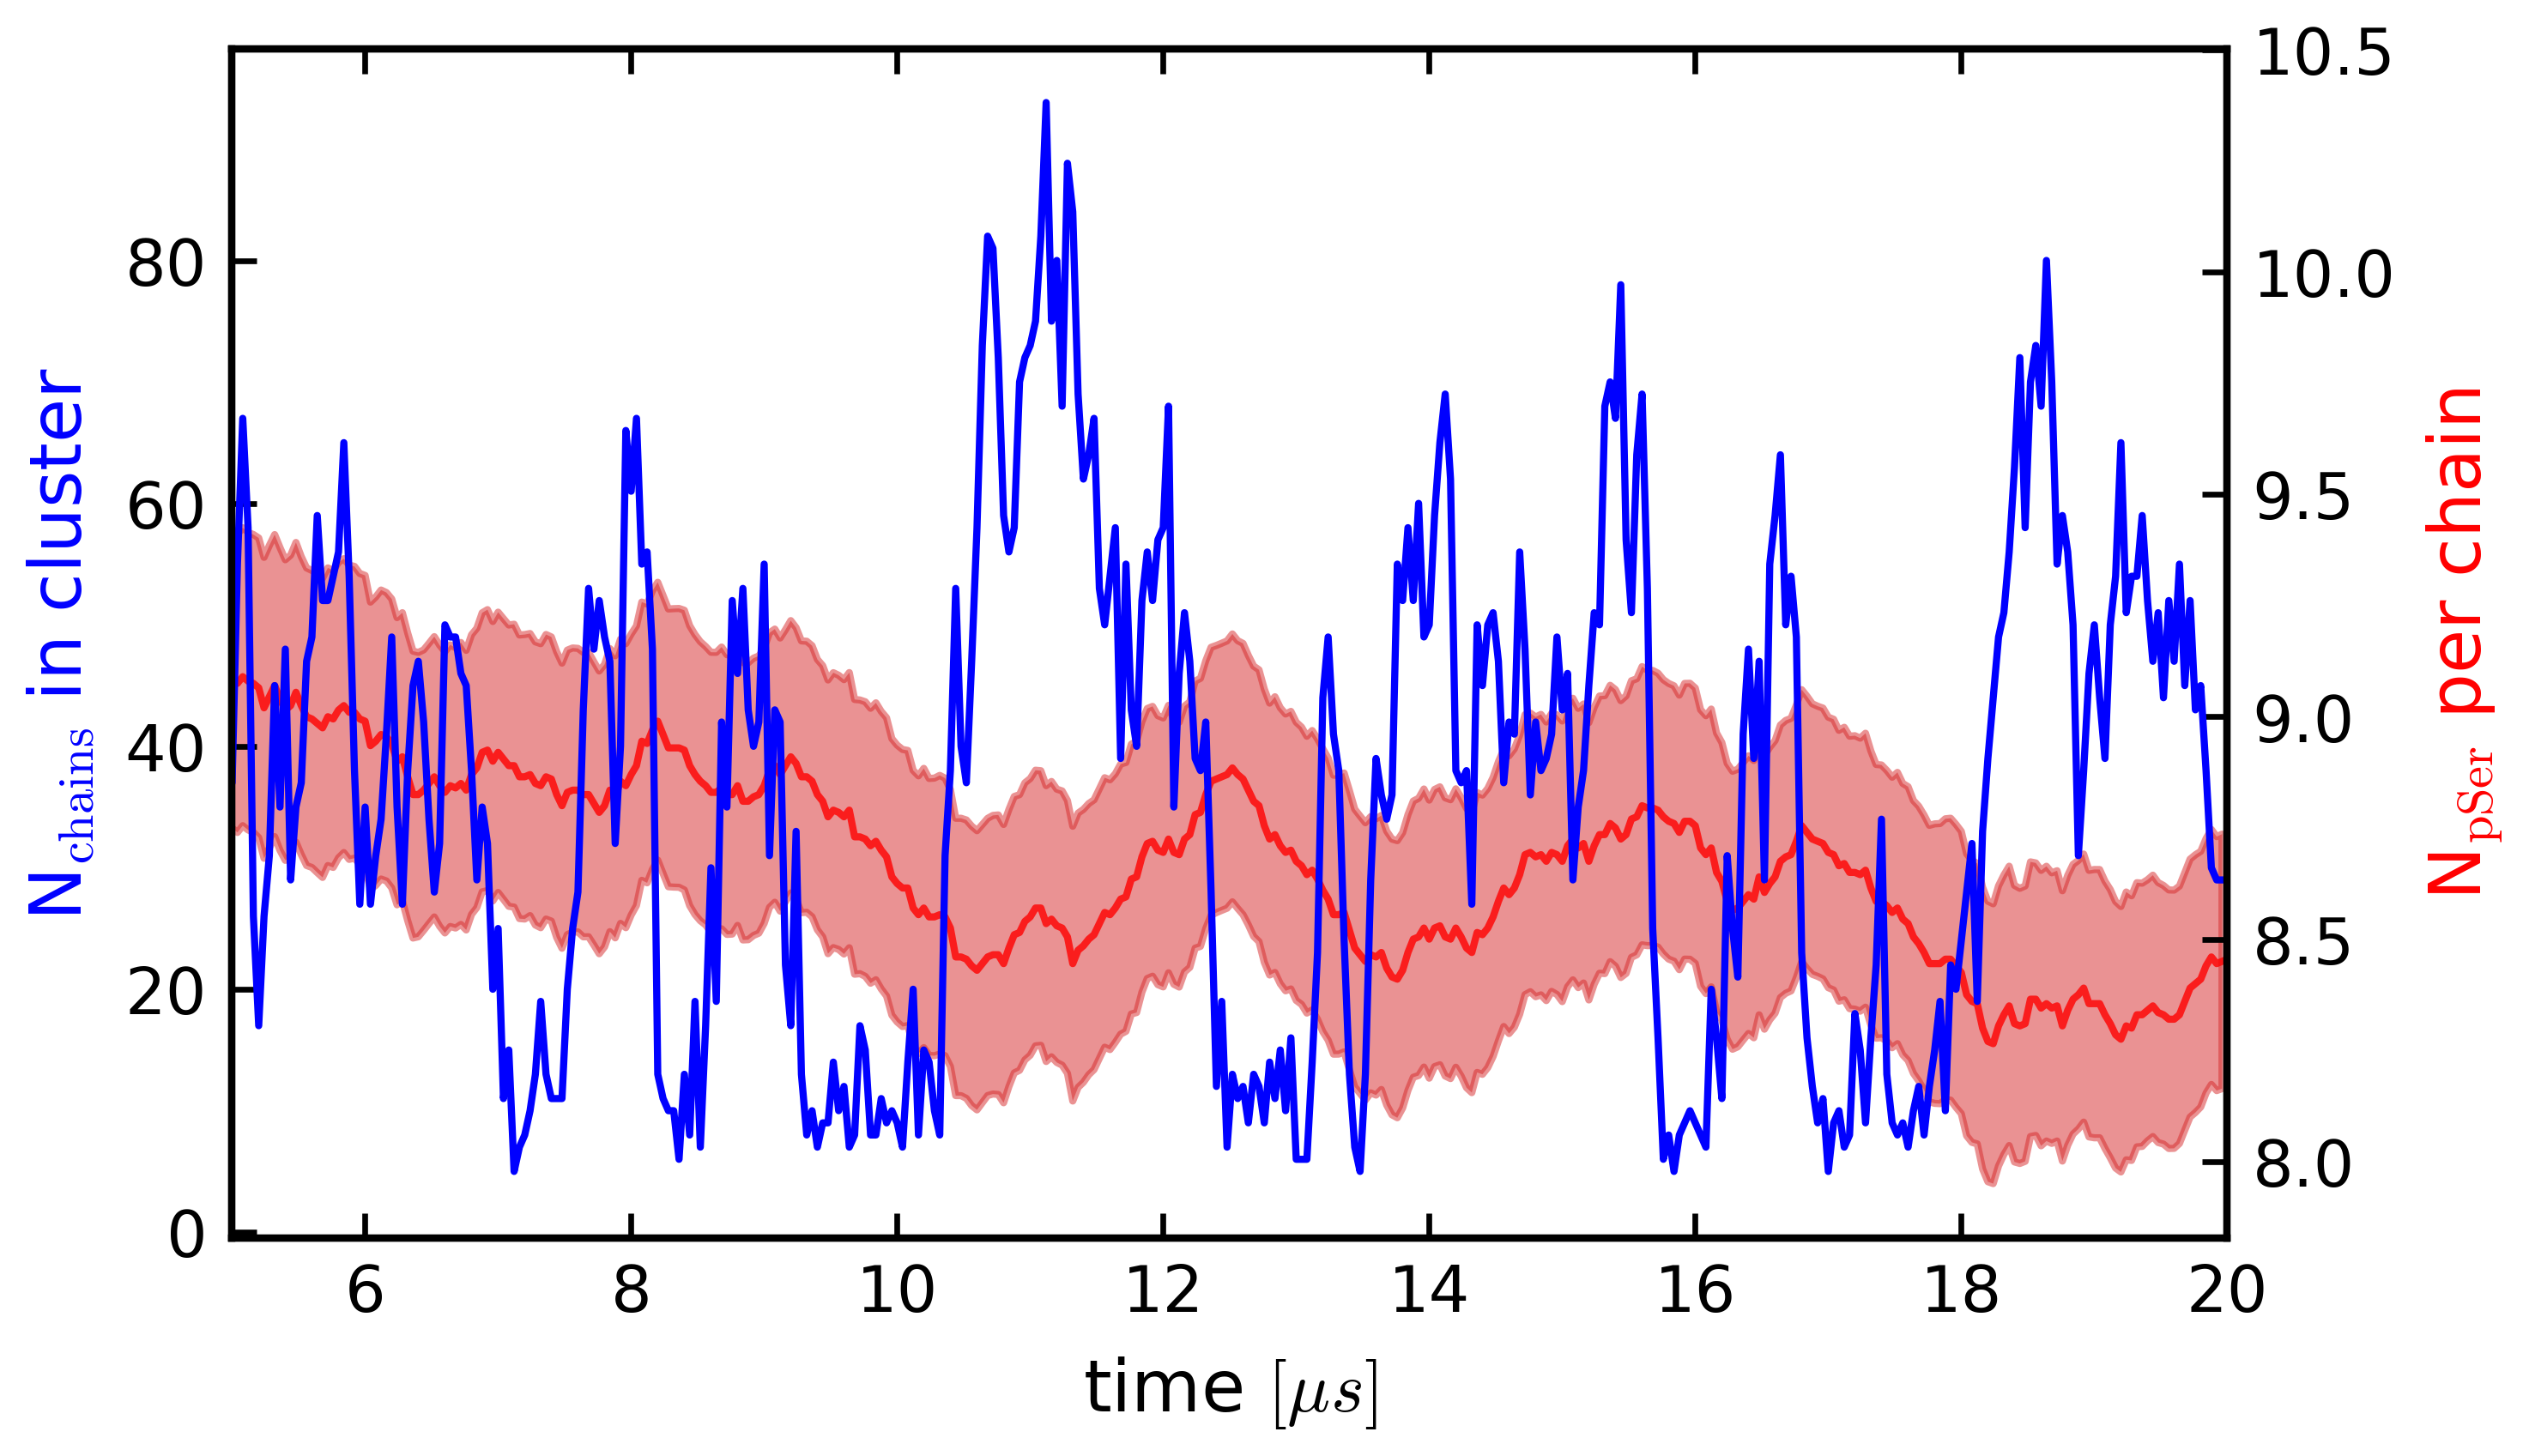

In [47]:
condensate_size_t = np.max(n_chains_arr_pre, axis=1)

time_step_5us = times_5us*200000/1e8
time_step_ss = np.append( np.append( np.append(time_step_5us, time_step_5us+5), time_step_5us+10 ), time_step_5us+15 )
pSer_200_2_10_till10us = np.append(pSer_200_2_10_pre, pSer_200_2_10_pre1)
d_pSer_200_2_10_till10us = np.append(d_pSer_200_2_10_pre, d_pSer_200_2_10_pre1)
pSer_200_2_10_till15us = np.append(pSer_200_2_10_till10us, pSer_200_2_10_pre2)
d_pSer_200_2_10_till15us = np.append(d_pSer_200_2_10_till10us, d_pSer_200_2_10_pre2)
pSer_200_2_10_till20us = np.append(pSer_200_2_10_till15us, pSer_200_2_10_pre3)
d_pSer_200_2_10_till20us = np.append(d_pSer_200_2_10_till15us, d_pSer_200_2_10_pre3)

fig, ax1 = plt.subplots(figsize=(5, 3))

ax1.plot(time_step_ss, condensate_size_t, 'b')
ax1.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b')

ax2 = ax1.twinx()
ax2.set_zorder(ax1.get_zorder() - 1)  

ax2.plot(time_step_ss, pSer_200_2_10_till20us, 'r', alpha=0.8)
ax2.fill_between(time_step_ss, pSer_200_2_10_till20us-d_pSer_200_2_10_till20us, pSer_200_2_10_till20us+d_pSer_200_2_10_till20us, color='tab:red', alpha=0.5, label='2 CK1d, 10 PP3')

ax1.set_xlabel(r'time $[\mu s]$')
ax2.set_ylabel(r'N$_{\mathrm{pSer}}$ per chain', color='r')
ax2.patch.set_visible(False)  
ax1.patch.set_visible(False)  

#ax1.set_ylim(3,5)
ax1.set_xlim(5,20)
#ax1.legend(ncols=2, loc='lower right')
filename = '/localscratch/zippoema/project_ness/plots/search_steadystate/cluster_size_200-tdp-lcd-2000pser_2-ck1d-open_10-pp3'
#plt.savefig(filename+'.png', dpi=600)
#plt.savefig(filename+'.pdf', dpi=600)

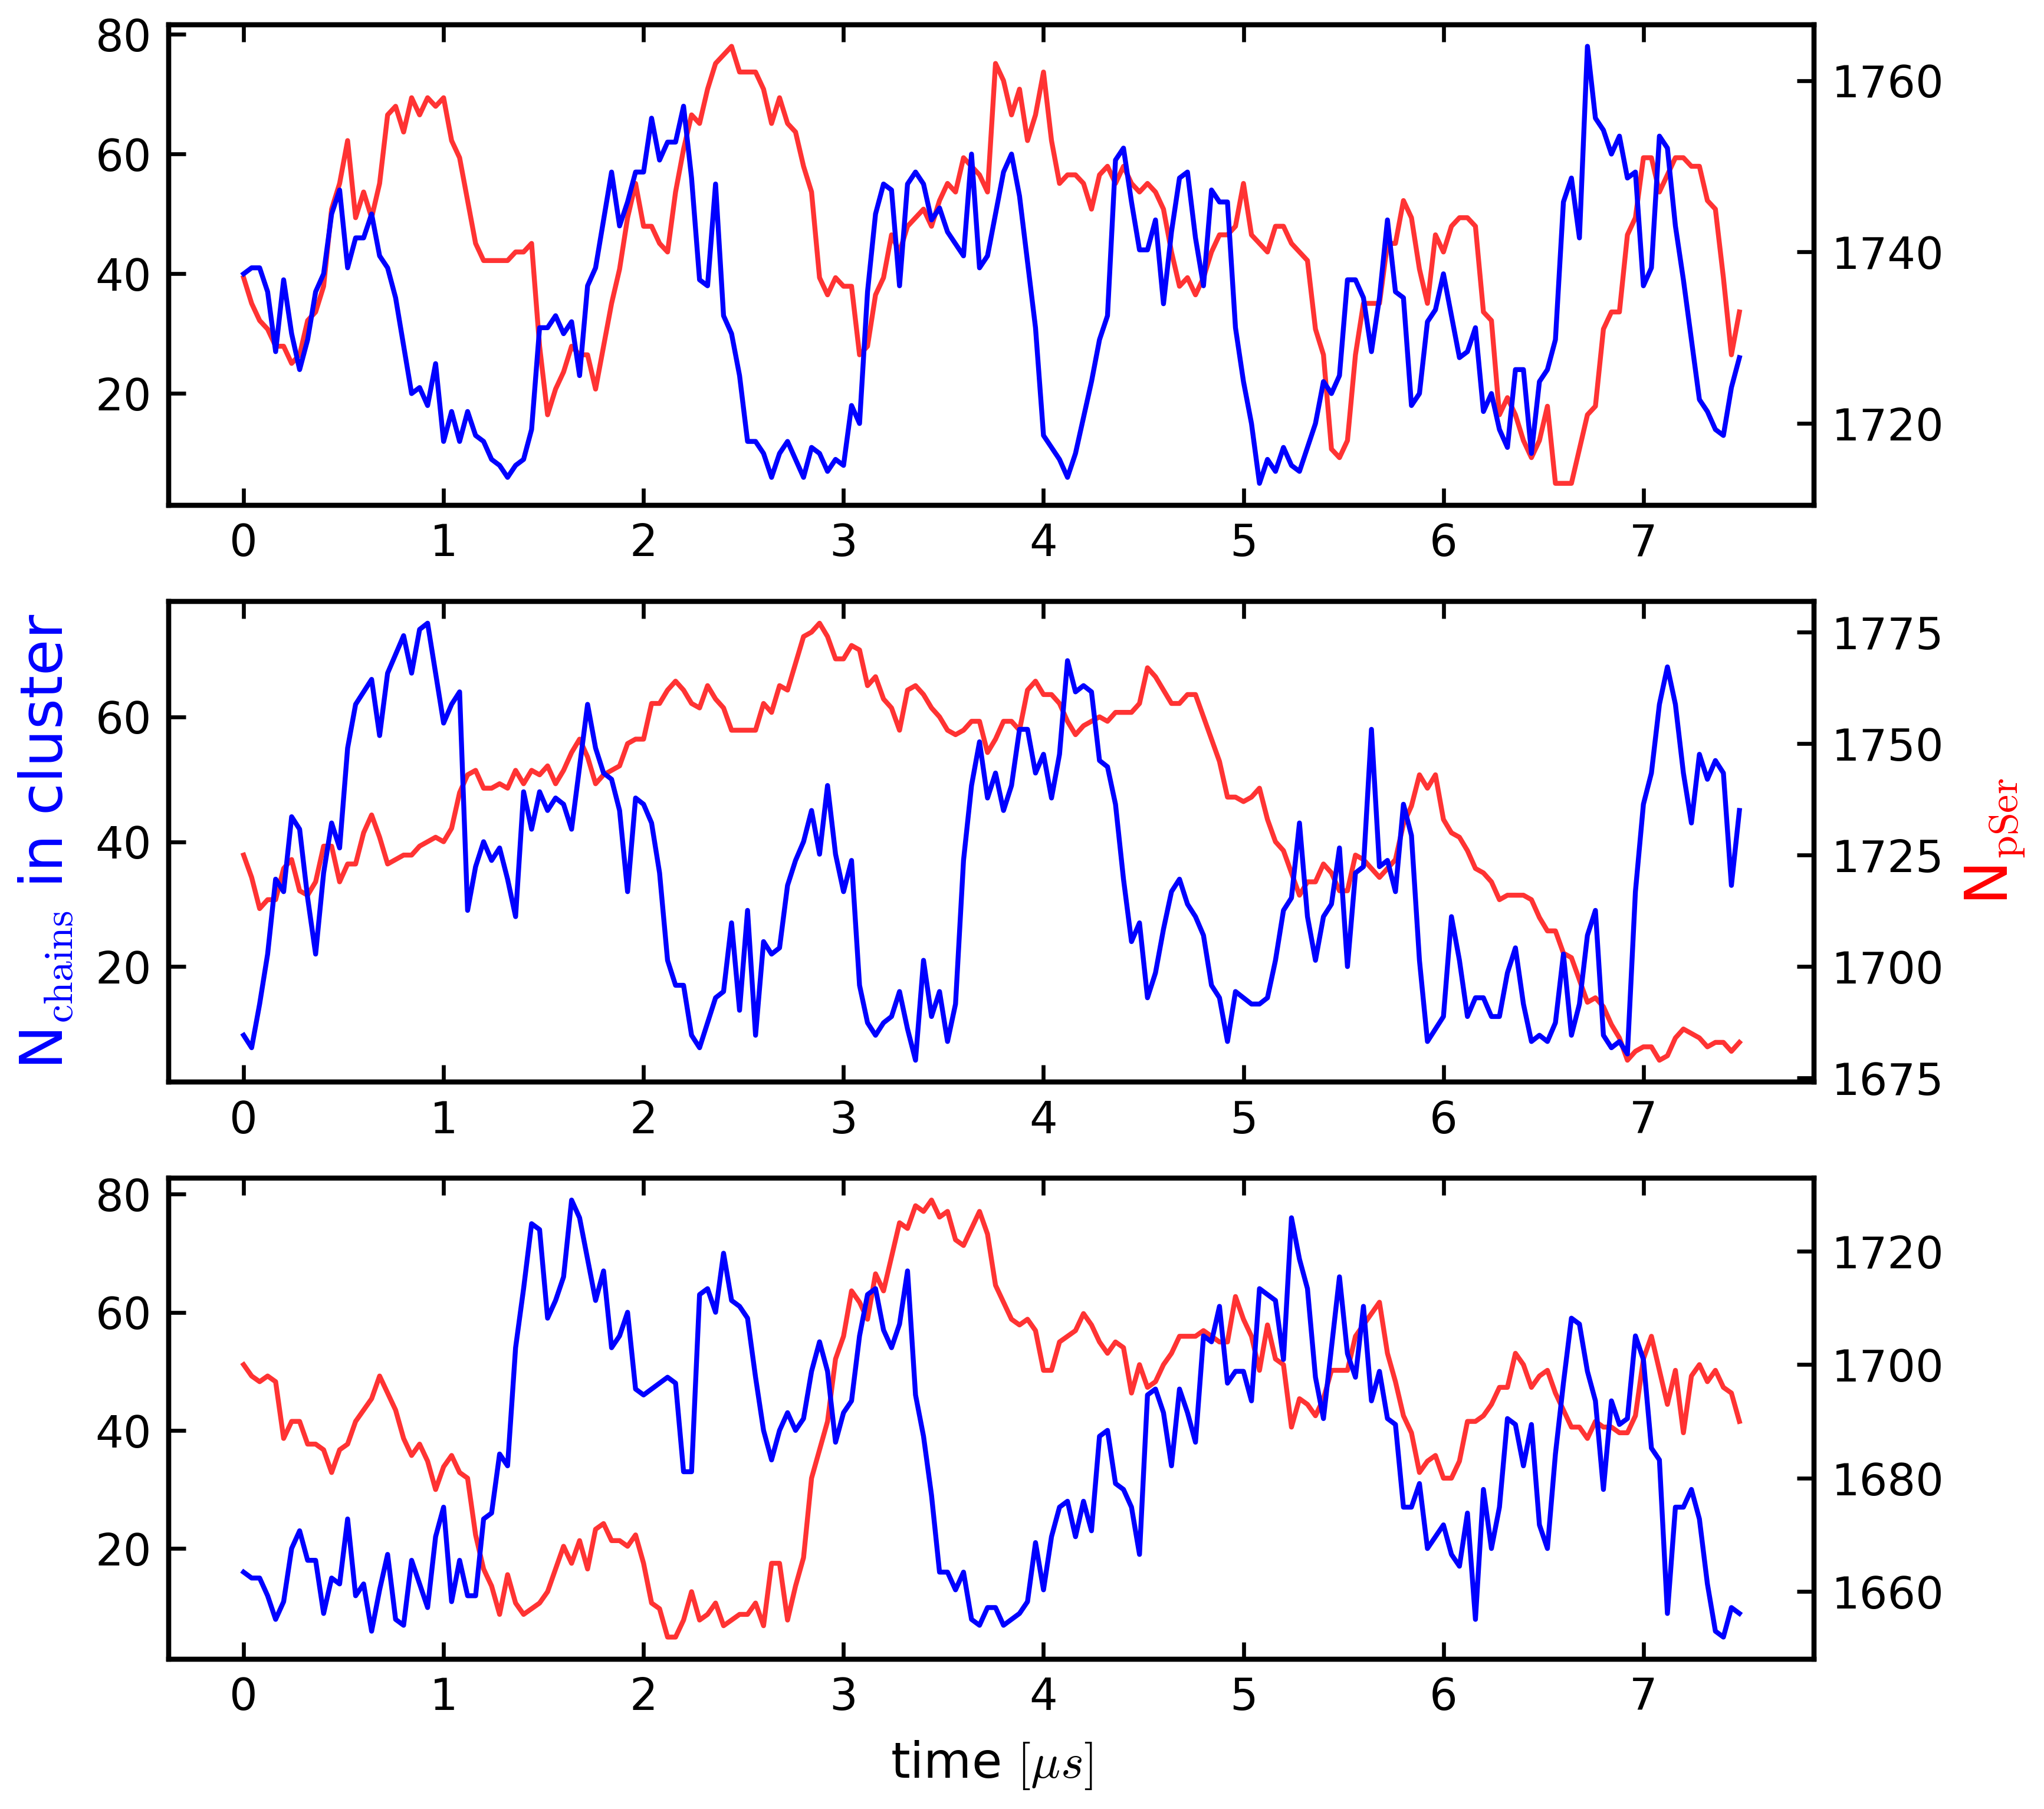

In [39]:
time_step_ss = times_ss*200000/1e8
#time_step_ss = np.append( np.append( np.append(time_step_ss, time_step_ss+5), time_step_ss+10 ), time_step_ss+15 )
'''
pSer_200_2_10_till10us = np.append(pSer_200_2_10, pSer_200_2_10_5us)
d_pSer_200_2_10_till10us = np.append(d_pSer_200_2_10, d_pSer_200_2_10_5us)
pSer_200_2_10_till15us = np.append(pSer_200_2_10_till10us, pSer_200_2_10_10us)
d_pSer_200_2_10_till15us = np.append(d_pSer_200_2_10_till10us, d_pSer_200_2_10_10us)
pSer_200_2_10_till20us = np.append(pSer_200_2_10_till15us, pSer_200_2_10_15us)
d_pSer_200_2_10_till20us = np.append(d_pSer_200_2_10_till15us, d_pSer_200_2_10_15us)
'''
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(6, 6))

ax1.plot(time_step_ss, condensate_size_t1, 'b')
#ax1.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b')

ax2.plot(time_step_ss, condensate_size_t2, 'b')
ax2.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b', fontsize=12)

ax3.plot(time_step_ss, condensate_size_t3, 'b')
#ax3.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b')

ax11 = ax1.twinx()
ax11.set_zorder(ax1.get_zorder() - 1)  
ax22 = ax2.twinx()
ax22.set_zorder(ax2.get_zorder() - 1)  
ax33 = ax3.twinx()
ax33.set_zorder(ax3.get_zorder() - 1)  

ax11.plot(time_step_ss, pSer_200_2_10_1*200, 'r', alpha=0.8)
#ax11.fill_between(time_step_ss, pSer_200_2_10_1-d_pSer_200_2_10_1, pSer_200_2_10_1+d_pSer_200_2_10_1, color='tab:red', alpha=0.5, label='sim1')
ax22.plot(time_step_ss, pSer_200_2_10_2*200, 'r', alpha=0.8)
#ax22.fill_between(time_step_ss, pSer_200_2_10_2-d_pSer_200_2_10_2, pSer_200_2_10_2+d_pSer_200_2_10_2, color='tab:red', alpha=0.5, label='sim2')
ax33.plot(time_step_ss, pSer_200_2_10_3*200, 'r', alpha=0.8)
#ax33.fill_between(time_step_ss, pSer_200_2_10_3-d_pSer_200_2_10_3, pSer_200_2_10_3+d_pSer_200_2_10_3, color='tab:red', alpha=0.5, label='sim3')

ax3.set_xlabel(r'time $[\mu s]$')
ax22.set_ylabel(r'N$_{\mathrm{pSer}}$', color='r', fontsize=12)
ax11.patch.set_visible(False)  
ax1.patch.set_visible(False)  
ax22.patch.set_visible(False)  
ax2.patch.set_visible(False)  
ax33.patch.set_visible(False)  
ax3.patch.set_visible(False)  

#ax1.set_ylim(3,5)
#ax1.set_xlim(0,20)
#ax1.legend(ncols=2, loc='lower right')
filename = '/localscratch/zippoema/project_ness/plots/droplet_200-tdp43-lcd/oscillations/cluster_size_200-tdp-lcd-2000pser_2-ck1d-open_10-pp3'
plt.savefig(filename+'.png', dpi=600)
plt.savefig(filename+'.pdf', dpi=600)

(array([101.,  19.,   6.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14.]),
 <BarContainer object of 13 artists>)

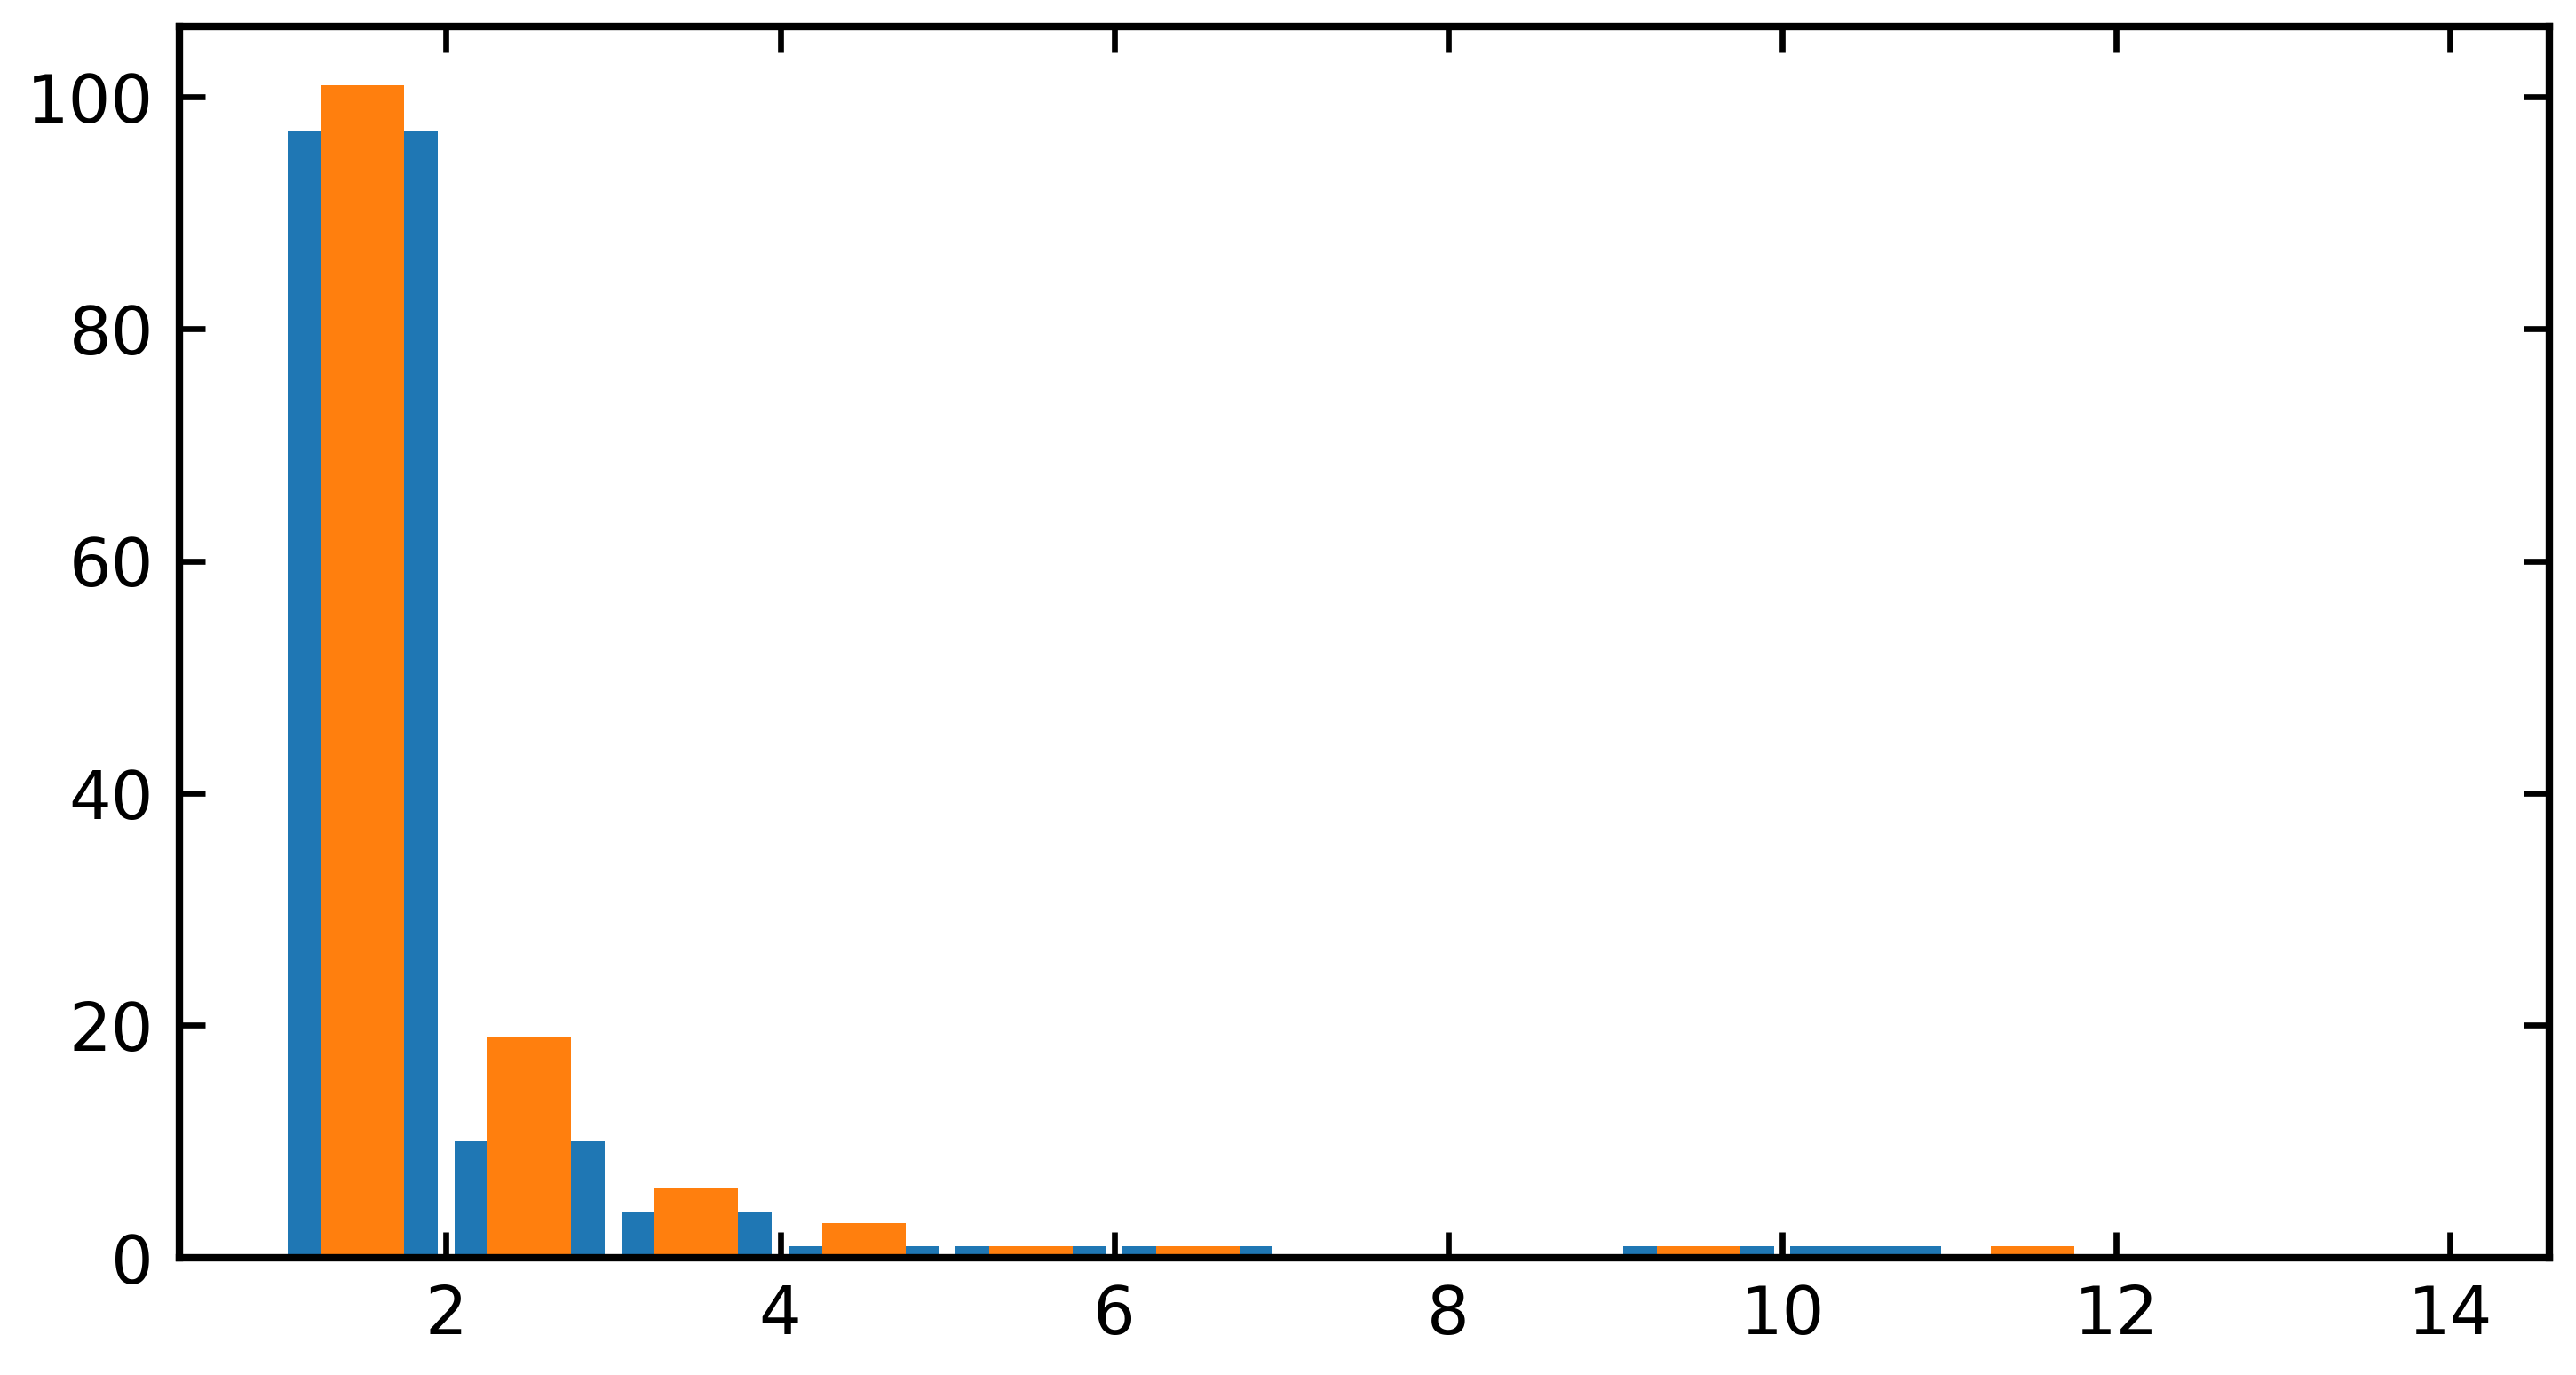

In [44]:
plt.figure()
plt.hist(n_chains_arr[124], bins=list(np.arange(1,15)), rwidth=0.9)
plt.hist(n_chains_arr[185], bins=list(np.arange(1,15)), rwidth=0.5)

In [37]:
n_chains_arr[120]

array([ 3.,  1.,  5.,  1.,  1.,  1.,  1.,  1.,  1., 48.,  5.,  1.,  1.,
        2.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        2.,  4.,  1.,  2.,  4.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,
        1.,  2.,  2.,  2.,  1.,  1.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  4.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,
        2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

### 

### NESS 

In [41]:
times_ss = np.arange(0,2500,20)
times_ss*200000/1e8

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
       1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
       1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16,
       2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 ,
       2.64, 2.68, 2.72, 2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04,
       3.08, 3.12, 3.16, 3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48,
       3.52, 3.56, 3.6 , 3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92,
       3.96, 4.  , 4.04, 4.08, 4.12, 4.16, 4.2 , 4.24, 4.28, 4.32, 4.36,
       4.4 , 4.44, 4.48, 4.52, 4.56, 4.6 , 4.64, 4.68, 4.72, 4.76, 4.8 ,
       4.84, 4.88, 4.92, 4.96])

In [43]:
pSer_200_2_12_1, d_pSer_200_2_12_1 = hpa.rates.pSer_per_chain(dirpath=path_drop+'sim_ness_200-tdp43-lcd_2-ck1d-open_12-pp3/', 
                                              file_suffix='ness_200-tdp43-lcd_2-com-ck1d-open_12-com-pp3_CAL3_dump.gsd', 
                                              n_sims=[1], times=times_ss, len_prot=154, n_prot=200)

pSer_200_2_12_2, d_pSer_200_2_12_2 = hpa.rates.pSer_per_chain(dirpath=path_drop+'sim_ness_200-tdp43-lcd_2-ck1d-open_12-pp3/', 
                                              file_suffix='ness_200-tdp43-lcd_2-com-ck1d-open_12-com-pp3_CAL3_dump.gsd', 
                                              n_sims=[2], times=times_ss, len_prot=154, n_prot=200)

pSer_200_2_12_3, d_pSer_200_2_12_3 = hpa.rates.pSer_per_chain(dirpath=path_drop+'sim_ness_200-tdp43-lcd_2-ck1d-open_12-pp3/', 
                                              file_suffix='ness_200-tdp43-lcd_2-com-ck1d-open_12-com-pp3_CAL3_dump.gsd', 
                                              n_sims=[3], times=times_ss, len_prot=154, n_prot=200)


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 41.66it/s]


In [46]:
dirpath=path_drop+'sim_ness_200-tdp43-lcd_2-ck1d-open_12-pp3/'
file_suffix='ness_200-tdp43-lcd_2-com-ck1d-open_12-com-pp3_CAL3_'

In [47]:
n_chains_arr1 = np.zeros((len(times_ss),200))
with gsd.hoomd.open(dirpath+f'sim1_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr1[i] = tmp_nc

n_chains_arr2 = np.zeros((len(times_ss),200))
with gsd.hoomd.open(dirpath+f'sim2_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr2[i] = tmp_nc

n_chains_arr3 = np.zeros((len(times_ss),200))
with gsd.hoomd.open(dirpath+f'sim3_'+file_suffix+'dump_centered.gsd', 'rb') as input_gsd:
    print(len(input_gsd))
    for i, tt in enumerate(tqdm(times_ss)):
        frame = input_gsd[int(tt)]
        tmp_nc = hpa.cluster.clusters_size_from_dbscan_pbc_fast(frame, np.array([100,100,100]), n_particles=30800, n_chains=200, eps=1, min_sample=2)/154.
        n_chains_arr3[i] = tmp_nc


3000


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:17<00:00,  7.01it/s]


3000


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:18<00:00,  6.91it/s]


3000


100%|█████████████████████████████████████████████████████████████████| 125/125 [00:17<00:00,  7.10it/s]


In [48]:
condensate_size_t1 = np.max(n_chains_arr1, axis=1)
condensate_size_t2 = np.max(n_chains_arr2, axis=1)
condensate_size_t3 = np.max(n_chains_arr3, axis=1)

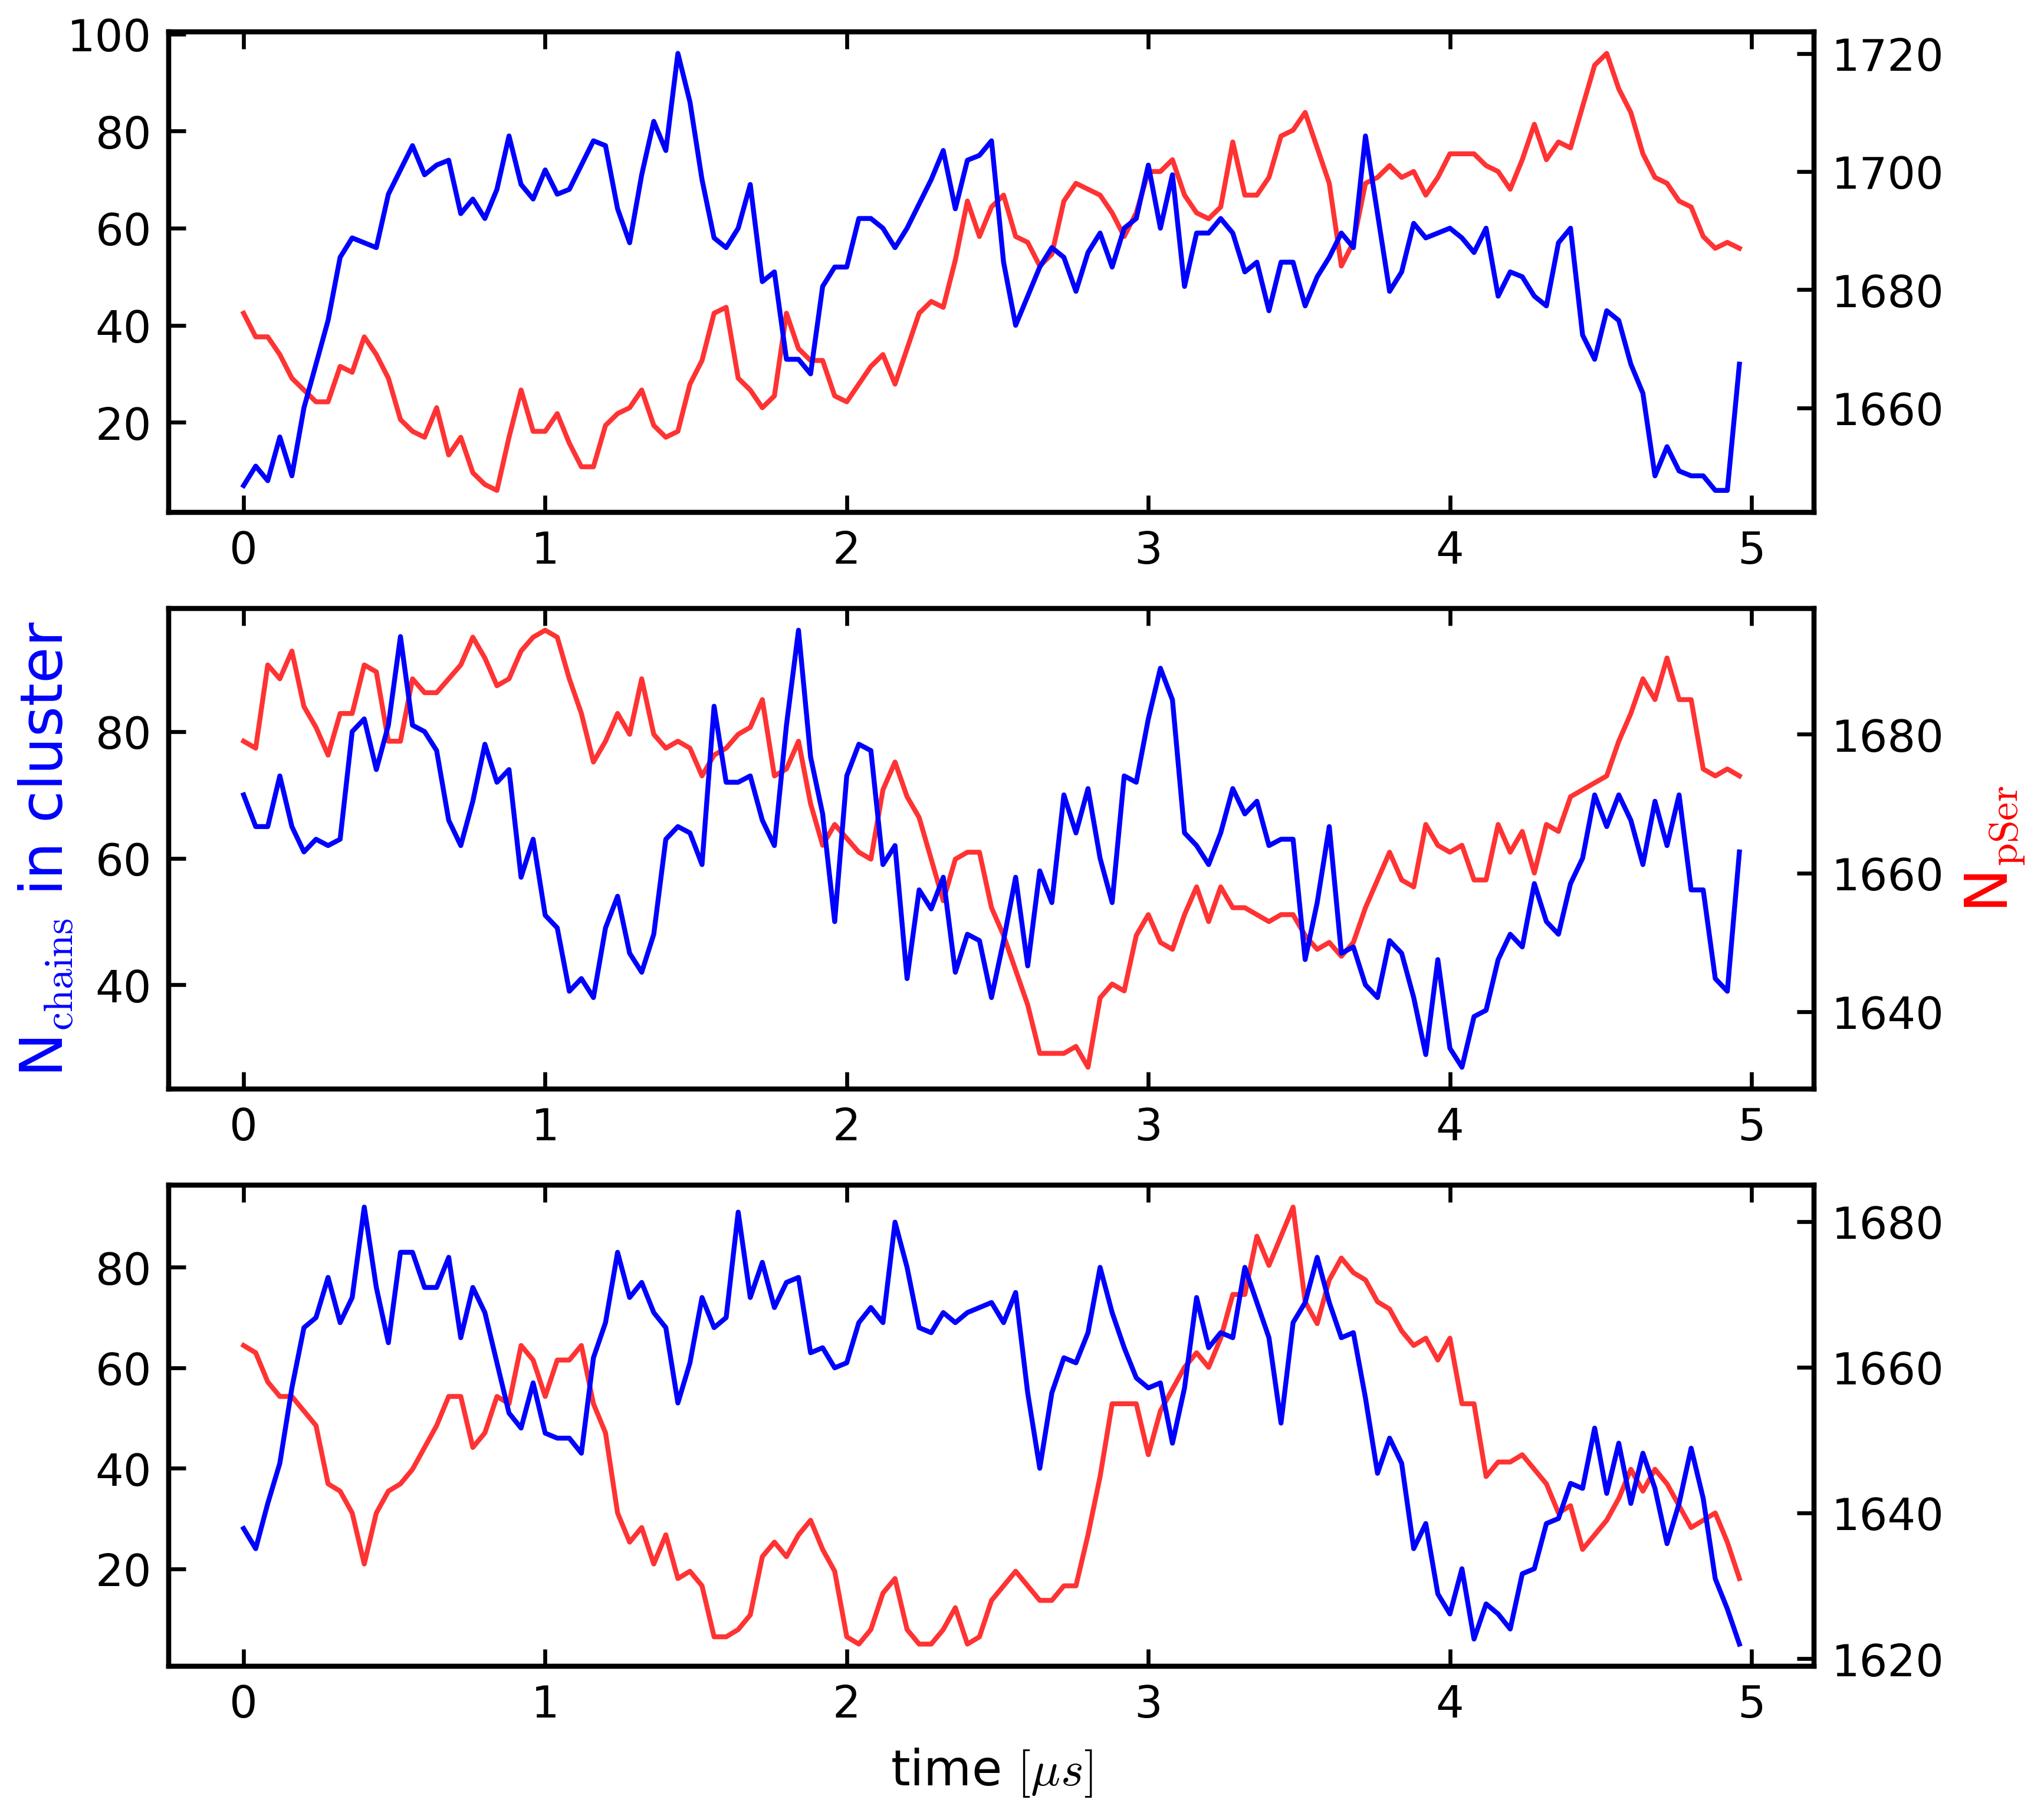

In [50]:
time_step_ss = times_ss*200000/1e8

fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(6, 6))

ax1.plot(time_step_ss, condensate_size_t1, 'b')
#ax1.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b')

ax2.plot(time_step_ss, condensate_size_t2, 'b')
ax2.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b', fontsize=12)

ax3.plot(time_step_ss, condensate_size_t3, 'b')
#ax3.set_ylabel(r'N$_{\mathrm{chains}}$ in cluster', color='b')

ax11 = ax1.twinx()
ax11.set_zorder(ax1.get_zorder() - 1)  
ax22 = ax2.twinx()
ax22.set_zorder(ax2.get_zorder() - 1)  
ax33 = ax3.twinx()
ax33.set_zorder(ax3.get_zorder() - 1)  

ax11.plot(time_step_ss, pSer_200_2_12_1*200, 'r', alpha=0.8)
#ax11.fill_between(time_step_ss, pSer_200_2_10_1-d_pSer_200_2_10_1, pSer_200_2_10_1+d_pSer_200_2_10_1, color='tab:red', alpha=0.5, label='sim1')
ax22.plot(time_step_ss, pSer_200_2_12_2*200, 'r', alpha=0.8)
#ax22.fill_between(time_step_ss, pSer_200_2_10_2-d_pSer_200_2_10_2, pSer_200_2_10_2+d_pSer_200_2_10_2, color='tab:red', alpha=0.5, label='sim2')
ax33.plot(time_step_ss, pSer_200_2_12_3*200, 'r', alpha=0.8)
#ax33.fill_between(time_step_ss, pSer_200_2_10_3-d_pSer_200_2_10_3, pSer_200_2_10_3+d_pSer_200_2_10_3, color='tab:red', alpha=0.5, label='sim3')

ax3.set_xlabel(r'time $[\mu s]$')
ax22.set_ylabel(r'N$_{\mathrm{pSer}}$', color='r', fontsize=12)
ax11.patch.set_visible(False)  
ax1.patch.set_visible(False)  
ax22.patch.set_visible(False)  
ax2.patch.set_visible(False)  
ax33.patch.set_visible(False)  
ax3.patch.set_visible(False)  

#ax1.set_ylim(3,5)
#ax1.set_xlim(0,20)
#ax1.legend(ncols=2, loc='lower right')
filename = '/localscratch/zippoema/project_ness/plots/droplet_200-tdp43-lcd/cluster_size_200-tdp-lcd_2-ck1d-open_12-pp3'
#plt.savefig(filename+'.png', dpi=600)
#plt.savefig(filename+'.pdf', dpi=600)